In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
from laser_dataset import FileReader, LaserDataInteractor
from data_preprocessing import process_laser_data

## (0) Load the metadata (Versuchstabelle)

In [8]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="C:G, I, R,S",
    nrows=71,
    decimal=','
)
metadf

,HV-Data,QASS,SoundBook,DEWETRON,Probe,Spalt [mm],tstart [s],tend [s]
0,01_0_1_Spalt_pneu,45,iHub2023_001,01_0_1_Spalt_pneu,standard,0.1,0.2520,1.0606
1,02_0_1_Spalt_pneu,46,iHub2023_002,02_0_1_Spalt_pneu,standard,0.1,0.2504,1.0566
2,03_0_1_Spalt_pneu,47,iHub2023_003,03_0_1_Spalt_pneu,standard,0.1,0.2501,1.0581
3,04_0_1_Spalt_pneu,48,iHub2023_004,04_0_1_Spalt_pneu,standard,0.1,0.2514,1.0594
4,05_0_1_Spalt_pneu,49,iHub2023_005,05_0_1_Spalt_pneu,standard,0.1,0.2513,1.0583
...,...,...,...,...,...,...,...,...
66,67_0_2_Spalt_pneu_CJ_X2,130,iHub2023_075,67_0_2_Spalt_pneu_CJ_X2,standard,0.2,0.2489,1.0561
67,68_0_2_Spalt_pneu_CJ_X2,131,iHub2023_076,68_0_2_Spalt_pneu_CJ_X2,standard,0.2,0.2500,1.0564
68,69_0_2_Spalt_pneu_CJ_X2,132,iHub2023_077,69_0_2_Spalt_pneu_CJ_X2,standard,0.2,0.2498,1.0557
69,70_0_2_Spalt_pneu_CJ_X2,133,iHub2023_078,70_0_2_Spalt_pneu_CJ_X2,standard,0.2,0.2494,1.0563


## (1) Load the QASS data

In [16]:
# Path to the data
path_qass = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/02_QASS'

# Example trial
dataID = 1
row = dataID - 1
fname_dew = metadf['DEWETRON'][row]
qassNo = str(metadf['QASS'][row]).zfill(3)

# Measurement parameters
fs_qass = 6.25*10**6 # [Hz]
# Signal processing parameters
f_range_sb = [50*10**3, 450*10**3] # [Hz]
f_range_ab = [5*10**3, 200*10**3] # [Hz]
w = 1.0*10**-3 #[s], smoothing duration

In [17]:
# Dataframe for the selected trial
trial_df = metadf[metadf['DEWETRON']==fname_dew].reset_index(drop=True)
trial_df

,HV-Data,QASS,SoundBook,DEWETRON,Probe,Spalt [mm],tstart [s],tend [s]
0,01_0_1_Spalt_pneu,45,iHub2023_001,01_0_1_Spalt_pneu,standard,0.1,0.252,1.0606


In [18]:
interactor = LaserDataInteractor()
interactor.df = metadf
interactor.df_row = fname_dew
#--- load the raw data
s1 = interactor.load(chNo=1, path=path_qass)
s2 = interactor.load(chNo=2, path=path_qass)
s3 = interactor.load(chNo=3, path=path_qass)

ZeroDivisionError: float division by zero

In [7]:
# Trim the signals
T = 1.5 #[s], shortened recording duration
N = int(T* fs_qass)
s1 = s1[:N]
s2 = s2[:N]
s3 = s3[:N]
t = 1/fs_qass* np.arange(0, len(s3))

In [8]:
interactor.fname

'/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS/20231016_TU_Ilmenau_Process_064_Ch3_SIG_Raw_compress_1'

## (2) Load the delays -> adjust the time

In [9]:
path_delay = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_delays'
info_df = pd.read_csv(f'{path_delay}/delays_QASS.csv') 
delay = info_df['delay[s]'][info_df['QASS'] == int(qassNo)].item() #[s]
#N = int(delay/
print(f'delay = {round(10**3*delay, 2)}ms')

delay = 1.87ms


## (3) Process the QASS data

In [10]:
#s1_proc = process_laser_data(s1, f_range_sb, 1/fs_qass, w)
#s2_proc = process_laser_data(s2, f_range_sb, 1/fs_qass, w)
s3_proc = process_laser_data(s3, f_range_ab, 1/fs_qass, w)

## (4) Delay correction

In [11]:
t_start_cam = trial_df['tstart [s]'].item()
t_end_cam = trial_df['tend [s]'].item()
t_start_qass = t_start_cam - delay
t_end_qass = t_end_cam - delay

print(f't_start: HD camera = {t_start_cam}s, QASS = {t_start_qass}s')
print(f't_end: HD camera = {t_end_cam}s, QASS = {t_end_qass}s')


t_start: HD camera = 0.2508s, QASS = 0.24892607500000002s
t_end: HD camera = 1.057s, QASS = 1.055126075s


In [12]:
tau1 = np.linspace(t_start_cam, t_end_cam, 6) 
tau2 = np.linspace(t_start_qass, t_end_qass, 6)

## (5) Check the raw data

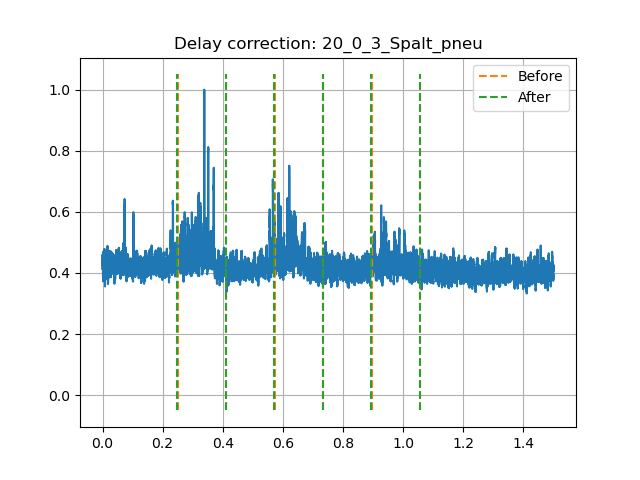

In [17]:
%matplotlib widget
#%matplotlib inline

plt.figure()
plt.title(f'Delay correction: {fname_dew}')
plt.plot(t, s3_proc/np.abs(s3_proc).max())
plt.vlines(
    x=tau1, #[t_start_cam, t_end_cam], 
    ymin=-0.05, ymax=1.05, 
    linestyle='--', color='C1', label='Before'
)
plt.vlines(
    x=tau2,#[t_start_qass, t_end_qass], 
    ymin=-0.05, ymax=1.05, 
    linestyle='--', color='C2', label='After'
)
plt.legend(loc='upper right')
plt.grid(True)

In [14]:
# STFT parameters
NFFT = 2048 
#Fs=None, 
#Fc=None, 
detrend = None 
#window=None, -> Hanning window
noverlap = int(NFFT/2) 
cmap= 'rainbow' 
#xextent=None, 
#pad_to=None, 
sides = 'onesided' 
scale_by_freq=True # same as matlab 
mode='psd' 
scale='dB'
vmax=10 #[dB]
vmin=-140 #[dB] 


# All signals in a list format
S = [s1, s2, s3]

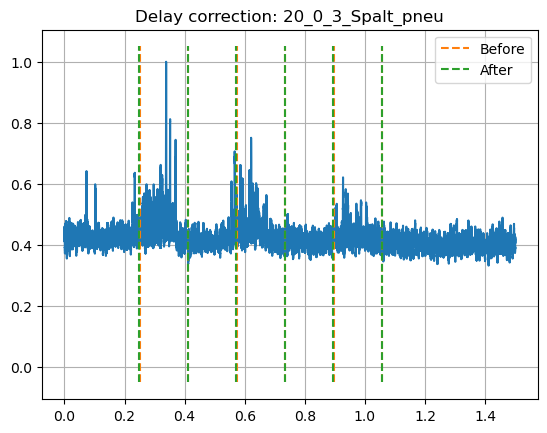

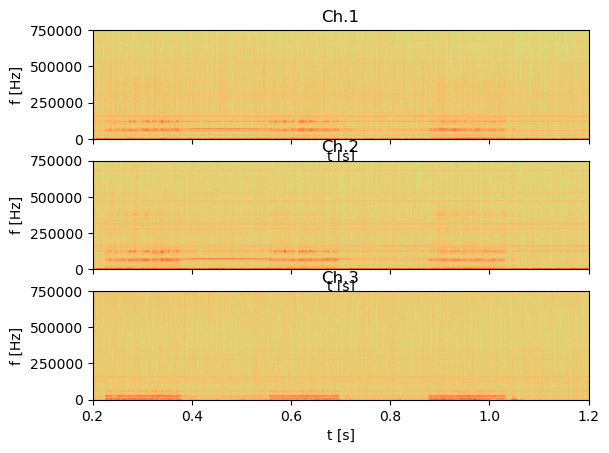

In [15]:
#%matplotlib widget
%matplotlib inline

fig, axs = plt.subplots(nrows=3, sharex=True)

for idx, ax in enumerate(axs.flatten()):
    Pxx, freqs, t_bins, im = ax.specgram(
        S[idx], 
        NFFT=NFFT, 
        Fs=fs_qass,
        detrend = detrend,
        noverlap = noverlap, 
        cmap= cmap, 
        sides = sides, 
        scale_by_freq=scale_by_freq, 
        mode=mode, 
        scale=scale,
        vmax=vmax,
        vmin=vmin,
    )
    # Prettier
    ax.set_title(f'Ch.{idx+1}')
    ax.set_xlabel('t [s]')
    ax.set_ylabel('f [Hz]')
    ax.set_xlim(0.2, 1.2)
    ax.set_ylim(0.0, 0.75*10**6)



In [16]:
plt.close('all')